In [1]:
#Data manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) #Show all columns of the dataframe

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#Pipeline
from sklearn.pipeline import Pipeline

#Data preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn_pandas import DataFrameMapper

#Split the data into train, validation and test
from sklearn.model_selection import train_test_split

#Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, pairwise_distances

#Model selection
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV


#Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#load and save data
import pickle

#Feature engineering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier  # or XGBRegressor depending on your task
# Fit PCA

In [2]:
df = pd.read_csv('../data/processed_data.csv')
#df = pd.read_csv('../data/data_for_modelling.csv')

In [3]:
#New features

#Over price
df['ovr_price'] = df['ovrrev_Mean']/(df['ovrmou_Mean']+1)

#Minutes pricing
df['mou_price'] = df['rev_Mean']/(df['mou_Mean']+1)  #Minimum value of mou_Mean = 0.. 0.25.. 

#Percentage of blocked/dropped calls
df['drop_blk_percentage'] = (df['drop_blk_Mean'])/(df['attempt_Mean']+1)

#Month segmentation
df['month_segmentation'] = np.where(df['months']<=11, '-12','12-14')
df['month_segmentation'] = np.where(df['months']>14, '14-',df['month_segmentation'])

new_features = ['ovr_price', 'mou_price', 'drop_blk_percentage', 'month_segmentation']

In [4]:
#Columns to drop (EDA)
columns_to_drop = ['billing_diff','avg_adj','adjrev','adjmou','adjqty','peak_vce_Mean','mou_peav_Mean',
                   'opk_vce_Mean','mou_opkv_Mean','peak_diff','totrev','totmou','totcalls','call_made_received',
                   'call_made_received_bool','mou_rvce_Mean','mou_cvce_Mean','inonemin_Mean','mouiwylisv_Mean',
                   'mouowylisv_Mean','owylis_vce_Mean','iwylis_vce_Mean','total_calls','unan_vce_Mean',
                   'plcd_vce_Mean','recv_vce_Mean','comp_vce_Mean','unan_ratio']

columns_high_correlated = ['avgmou','avg6mou','avg3mou', 'avgrev','avg6rev','avg3rev','avgqty','avg6qty','avg3qty','ovrmou_Mean','complete_Mean']

In [5]:
columns_to_categorical = ['ovrmou_Mean','ovrrev_Mean','iwylis_vce_Mean','mouiwylisv_Mean', 'custcare_Mean', ]

columns_to_log = ['totmrc_Mean','rev_Mean','mou_Mean','ovrmou_Mean','ovrrev_Mean',
                  'unan_vce_Mean','plcd_vce_Mean','recv_vce_Mean','comp_vce_Mean',
                 'inonemin_Mean','mou_cvce_Mean','mou_rvce_Mean','owylis_vce_Mean',
                 'mouowylisv_Mean','peak_vce_Mean', 'mou_peav_Mean','opk_vce_Mean',
                 'mou_opkv_Mean','drop_blk_Mean','attempt_Mean','complete_Mean','totcalls','totmou',
                 'totrev','adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou',
                'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty',
                'avg6rev','mou_price', 'ovr_price', 'drop_blk_percentage','custcare_Mean','iwylis_vce_Mean','mouiwylisv_Mean',] 


columns_to_scale = ['months', 'hnd_price', 'eqpdays','change_mou','change_rev']



columns_to_one_hot_enconde  = ['crclscod', 'asl_flag', 'area', 'dualband','refurb_new','marital', 'creditcd', 'month_segmentation']

df.columns = df.columns.astype('str')

## Custom functions to fit and transform the data

In [6]:
def fit_transform_df(df_transf):
    df_transf.reset_index(drop=True, inplace = True)
    # Transformação categórica

    if to_categorical:
        for column in columns_to_categorical:
            if column not in df_transf.columns:
                continue
        
            string_var = 'bool_' + column
            df_transf[string_var] = np.where(df_transf[column] == 0, 0, 1)
            df_transf = df_transf.drop(column, axis=1)

    if to_log:
        for column in columns_to_log:
            if column not in df_transf.columns:
                continue
            string_var = 'log_' + column
            df_transf[string_var] = np.log10(df_transf[column] + 1)
            df_transf = df_transf.drop(column, axis=1)


    
    # One-hot-encode
    lb_columns = {}
    for column in columns_to_one_hot_enconde:
        if column not in df_transf.columns:
            continue
        
        lb = LabelBinarizer()

        binarized_data = lb.fit_transform(df_transf[column])
        lb_columns[column] = lb
        
        if len(lb.classes_) <= 2:
            # Caso binário, adiciona apenas uma classe
            columns_name = column + '_' + lb.classes_[-1]
            binarized_df = pd.DataFrame(binarized_data, columns=[columns_name])
            df_transf = pd.concat([df_transf, binarized_df], axis=1)
            df_transf = df_transf.drop(column, axis=1)
        else:
            # Caso com mais de duas classes
            columns_name = [f'{column}_' + var for var in lb.classes_]
            binarized_df = pd.DataFrame(binarized_data, columns=columns_name)
            binarized_df = binarized_df.iloc[:, 1:]  # Remove a primeira coluna
            df_transf = pd.concat([df_transf, binarized_df], axis=1)
            df_transf = df_transf.drop(column, axis=1)
            
    # Z-scaling
    zscaler_columns = {}
    if to_standardize:
        if to_log:
            for column in ['log_' + col for col in columns_to_log] + columns_to_scale:
                if column not in df_transf.columns:
                    continue
                scaler = StandardScaler()
                df_transf[column] = scaler.fit_transform(df_transf[[column]])
                zscaler_columns[column] = scaler
        else:
            for column in columns_to_log + columns_to_scale:
                if column not in df_transf.columns:
                    continue
                scaler = StandardScaler()
                df_transf[column] = scaler.fit_transform(df_transf[[column]])
                zscaler_columns[column] = scaler
                
    return df_transf, lb_columns, zscaler_columns

In [7]:
def transform_df(df_transf, lb_columns, zscaler_columns):
    df_transf.reset_index(drop=True, inplace = True)

    if to_categorical:
        for column in columns_to_categorical:
            if column not in df_transf.columns:
                continue
        
            string_var = 'bool_' + column
            df_transf[string_var] = np.where(df_transf[column] == 0, 0, 1)
            df_transf = df_transf.drop(column, axis=1)

    # LOG
    if to_log:
        for column in columns_to_log:
            if column not in df_transf.columns:
                continue
            string_var = 'log_' + column
            df_transf[string_var] = np.log10(df_transf[column] + 1)
            df_transf = df_transf.drop(column, axis=1)


    
    # One-hot-encode
    for column in columns_to_one_hot_enconde:
        if column not in df_transf.columns:
            continue
        
        lb = lb_columns[column]

        binarized_data = lb.transform(df_transf[column])
        
        if len(lb.classes_) <= 2:
            # Caso binário, adiciona apenas uma classe
            columns_name = column + '_' + lb.classes_[-1]
            binarized_df = pd.DataFrame(binarized_data, columns=[columns_name])
            df_transf = pd.concat([df_transf, binarized_df], axis=1)
            df_transf = df_transf.drop(column, axis=1)
        else:
            # Caso com mais de duas classes
            columns_name = [f'{column}_' + var for var in lb.classes_]
            binarized_df = pd.DataFrame(binarized_data, columns=columns_name)
            binarized_df = binarized_df.iloc[:, 1:]  # Remove a primeira coluna
            df_transf = pd.concat([df_transf, binarized_df], axis=1)
            df_transf = df_transf.drop(column, axis=1)
            
    # Z-scaling
    if to_standardize:
        if to_log:
            for column in ['log_' + col for col in columns_to_log] + columns_to_scale:
                if column not in df_transf.columns:
                    continue
                scaler = zscaler_columns[column]
                df_transf[column] = scaler.fit_transform(df_transf[[column]])
        else:
            for column in columns_to_log + columns_to_scale:
                if column not in df_transf.columns:
                    continue
                scaler = zscaler_columns[column]
                df_transf[column] = scaler.fit_transform(df_transf[[column]])

    return df_transf


## Split data into train, validation and test

In [8]:
X = df.drop('churn', axis = 1)
y = df['churn']

In [9]:
test_proportion = 0.15
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_proportion, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_proportion/(1 - test_proportion), random_state=42)

In [10]:
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")

X_train: (55799, 56)
X_val: (11958, 56)
X_test: (11958, 56)
y_train: (55799,)
y_val: (11958,)
y_test: (11958,)


### Transforming the data

In [11]:
#First, lets see how the model behaves without transformations
to_categorical = False
to_log = False
to_standardize = False

In [12]:
X_train, lb_columns, zscaler_columns = fit_transform_df(X_train)
X_val = transform_df(X_val, lb_columns, zscaler_columns)
X_test = transform_df(X_test, lb_columns, zscaler_columns)

## Testing some models

### Logistic regression - baseline model

In [13]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter = 100, penalty='l1', solver='liblinear', C=0.1)

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Predict the validation data
y_pred = lr_model.predict(X_val)

C:\Users\giode\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.5984278307409265
Confusion Matrix:
[[3576 2432]
 [2370 3580]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      6008
           1       0.60      0.60      0.60      5950

    accuracy                           0.60     11958
   macro avg       0.60      0.60      0.60     11958
weighted avg       0.60      0.60      0.60     11958



### Trasforming some features

In [15]:
X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(X, y, test_size = test_proportion, random_state=42)

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train_val2, y_train_val2, test_size=test_proportion/(1 - test_proportion), random_state=42)

In [16]:
to_categorical = True
to_log = True
to_standardize = True

X_train2, lb_columns, zscaler_columns = fit_transform_df(X_train2)
X_val2 = transform_df(X_val2, lb_columns, zscaler_columns)
X_test2 = transform_df(X_test2, lb_columns, zscaler_columns)

X_train2.head()

,change_mou,change_rev,months,hnd_price,eqpdays,custcare_bool,bool_ovrmou_Mean,bool_ovrrev_Mean,bool_iwylis_vce_Mean,bool_mouiwylisv_Mean,bool_custcare_Mean,log_totmrc_Mean,log_rev_Mean,log_mou_Mean,log_unan_vce_Mean,log_plcd_vce_Mean,log_recv_vce_Mean,log_comp_vce_Mean,log_inonemin_Mean,log_mou_cvce_Mean,log_mou_rvce_Mean,log_owylis_vce_Mean,log_mouowylisv_Mean,log_peak_vce_Mean,log_mou_peav_Mean,log_opk_vce_Mean,log_mou_opkv_Mean,log_drop_blk_Mean,log_attempt_Mean,log_complete_Mean,log_totcalls,log_totmou,log_totrev,log_adjrev,log_adjmou,log_adjqty,log_avgrev,log_avgmou,log_avgqty,log_avg3mou,log_avg3qty,log_avg3rev,log_avg6mou,log_avg6qty,log_avg6rev,log_mou_price,log_ovr_price,log_drop_blk_percentage,crclscod_A2,crclscod_AA,crclscod_B,crclscod_B2,crclscod_BA,crclscod_C,crclscod_C2,crclscod_C5,crclscod_CA,crclscod_CY,crclscod_D,crclscod_D4,crclscod_D5,crclscod_DA,crclscod_E,crclscod_E4,crclscod_EA,crclscod_EM,crclscod_G,crclscod_GA,crclscod_I,crclscod_JF,crclscod_M,crclscod_U,crclscod_U1,crclscod_W,crclscod_Z,crclscod_Z4,crclscod_Z5,crclscod_ZA,crclscod_ZY,asl_flag_Y,area_CALIFORNIA NORTH AREA,area_CENTRAL/SOUTH TEXAS AREA,area_CHICAGO AREA,area_DALLAS AREA,area_DC/MARYLAND/VIRGINIA AREA,area_GREAT LAKES AREA,area_HOUSTON AREA,area_LOS ANGELES AREA,area_MIDWEST AREA,area_NEW ENGLAND AREA,area_NEW YORK CITY AREA,area_NORTH FLORIDA AREA,area_NORTHWEST/ROCKY MOUNTAIN AREA,area_OHIO AREA,area_PHILADELPHIA AREA,area_SOUTH FLORIDA AREA,area_SOUTHWEST AREA,area_TENNESSEE AREA,dualband_T,dualband_Y,refurb_new_R,marital_B,marital_M,marital_S,marital_U,creditcd_Y,month_segmentation_12-14,month_segmentation_14-
0,0.137229,0.112101,0.661597,-1.170801,1.317358,0,1,1,1,1,0,-0.552446,0.145390,-0.019998,-0.042695,0.447983,-0.346645,0.382923,-0.626742,0.369908,-0.099087,0.227563,0.418425,0.381856,0.452166,0.089833,-0.051412,1.639342,0.445044,0.379459,-0.037979,-0.050029,-0.426353,-0.249198,-0.053656,-0.041899,-1.245357,-0.479211,-0.501136,-0.039147,-0.062601,0.135533,-0.216830,-0.216045,-0.273468,-0.183146,1.267798,2.695339,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
1,-2.792691,-1.097284,-1.057654,0.542580,-1.486444,0,1,1,1,1,0,0.843009,1.119779,0.645390,1.190075,0.976942,1.167238,0.985351,1.443892,0.581257,0.823024,1.020585,0.540261,0.848736,0.441860,1.325586,0.862077,1.257454,0.978664,0.987193,0.913046,0.599062,0.558827,0.432284,0.577833,0.884260,1.868507,1.181821,1.587616,0.833186,1.188132,1.274145,1.119858,1.512342,1.853573,-0.303094,0.721946,0.072156,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0
2,0.143109,0.069521,1.463914,-0.656786,0.859165,1,0,0,1,1,1,0.843009,0.301255,0.411256,-0.669582,-0.165958,-0.233752,-0.145680,-0.505998,-0.348760,-0.256988,-0.215857,-0.359503,-0.250544,-0.558237,-0.022685,-0.121907,0.295903,0.431209,0.541130,0.577908,0.501068,1.083135,1.080317,0.503342,0.581965,0.065266,-0.165614,-0.104837,0.395253,0.259939,0.286565,0.307711,0.195458,0.292399,-0.335079,-0.972990,-0.118045,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1
3,1.144251,2.143882,-1.057654,1.741947,-1.414983,1,1,1,1,1,1,1.859919,1.449699,0.062208,-0.151641,0.241272,0.157167,0.290720,0.324211,0.389720,-0.081350,0.428705,0.076420,0.400628,0.516404,-0.245363,-0.203597,0.391815,0.238471,0.287335,-0.371024,-0.184137,0.229625,0.173460,-0.240884,-0.407826,1.493279,0.318836,0.155337,-0.163076,-0.219209,1.119038,-0.168257,-0.189801,1.327216,0.098545,1.034406,0.370228,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,0.434190,0.025481,0.203130,-1.170801,0.026852,1,0,0,0,0,1,-0.128105,-0.094289,0.296283,0.888755,0.417932,-0.322422,0.252009,-0.856916,0.637704,0.485666,0.037974,0.072339,0.008169,0.265730,0.344973,0.871342,0.829885,0.415013,0.248657,-0.138675,0.482572,0.2537

In [17]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter = 100, penalty='l1', solver='liblinear', C=0.1)
lr_model.fit(X_train2, y_train2)
y_pred = lr_model.predict(X_val2)

In [18]:
# Evaluate the performance
accuracy = accuracy_score(y_val2, y_pred)
conf_matrix = confusion_matrix(y_val2, y_pred)
class_report = classification_report(y_val2, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6012711155711657
Confusion Matrix:
[[3662 2346]
 [2422 3528]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61      6008
           1       0.60      0.59      0.60      5950

    accuracy                           0.60     11958
   macro avg       0.60      0.60      0.60     11958
weighted avg       0.60      0.60      0.60     11958



### Logistic Regression Highlights
- We achieved a recall and precision performance of 0.60.
- Converting the variables into categories and standardizing the numerical ones did not change the model's performance.

### Random Forest

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict the validation data
y_pred = rf_model.predict(X_val)

In [20]:
# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6196688409433015
Confusion Matrix:
[[3676 2332]
 [2216 3734]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.62      6008
           1       0.62      0.63      0.62      5950

    accuracy                           0.62     11958
   macro avg       0.62      0.62      0.62     11958
weighted avg       0.62      0.62      0.62     11958



### XGBoost

In [21]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict the validation data
y_pred = xgb_model.predict(X_val)

In [22]:
#Calculate the performance
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6219267436026091
Confusion Matrix:
[[3689 2319]
 [2202 3748]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      6008
           1       0.62      0.63      0.62      5950

    accuracy                           0.62     11958
   macro avg       0.62      0.62      0.62     11958
weighted avg       0.62      0.62      0.62     11958



### Feature importance

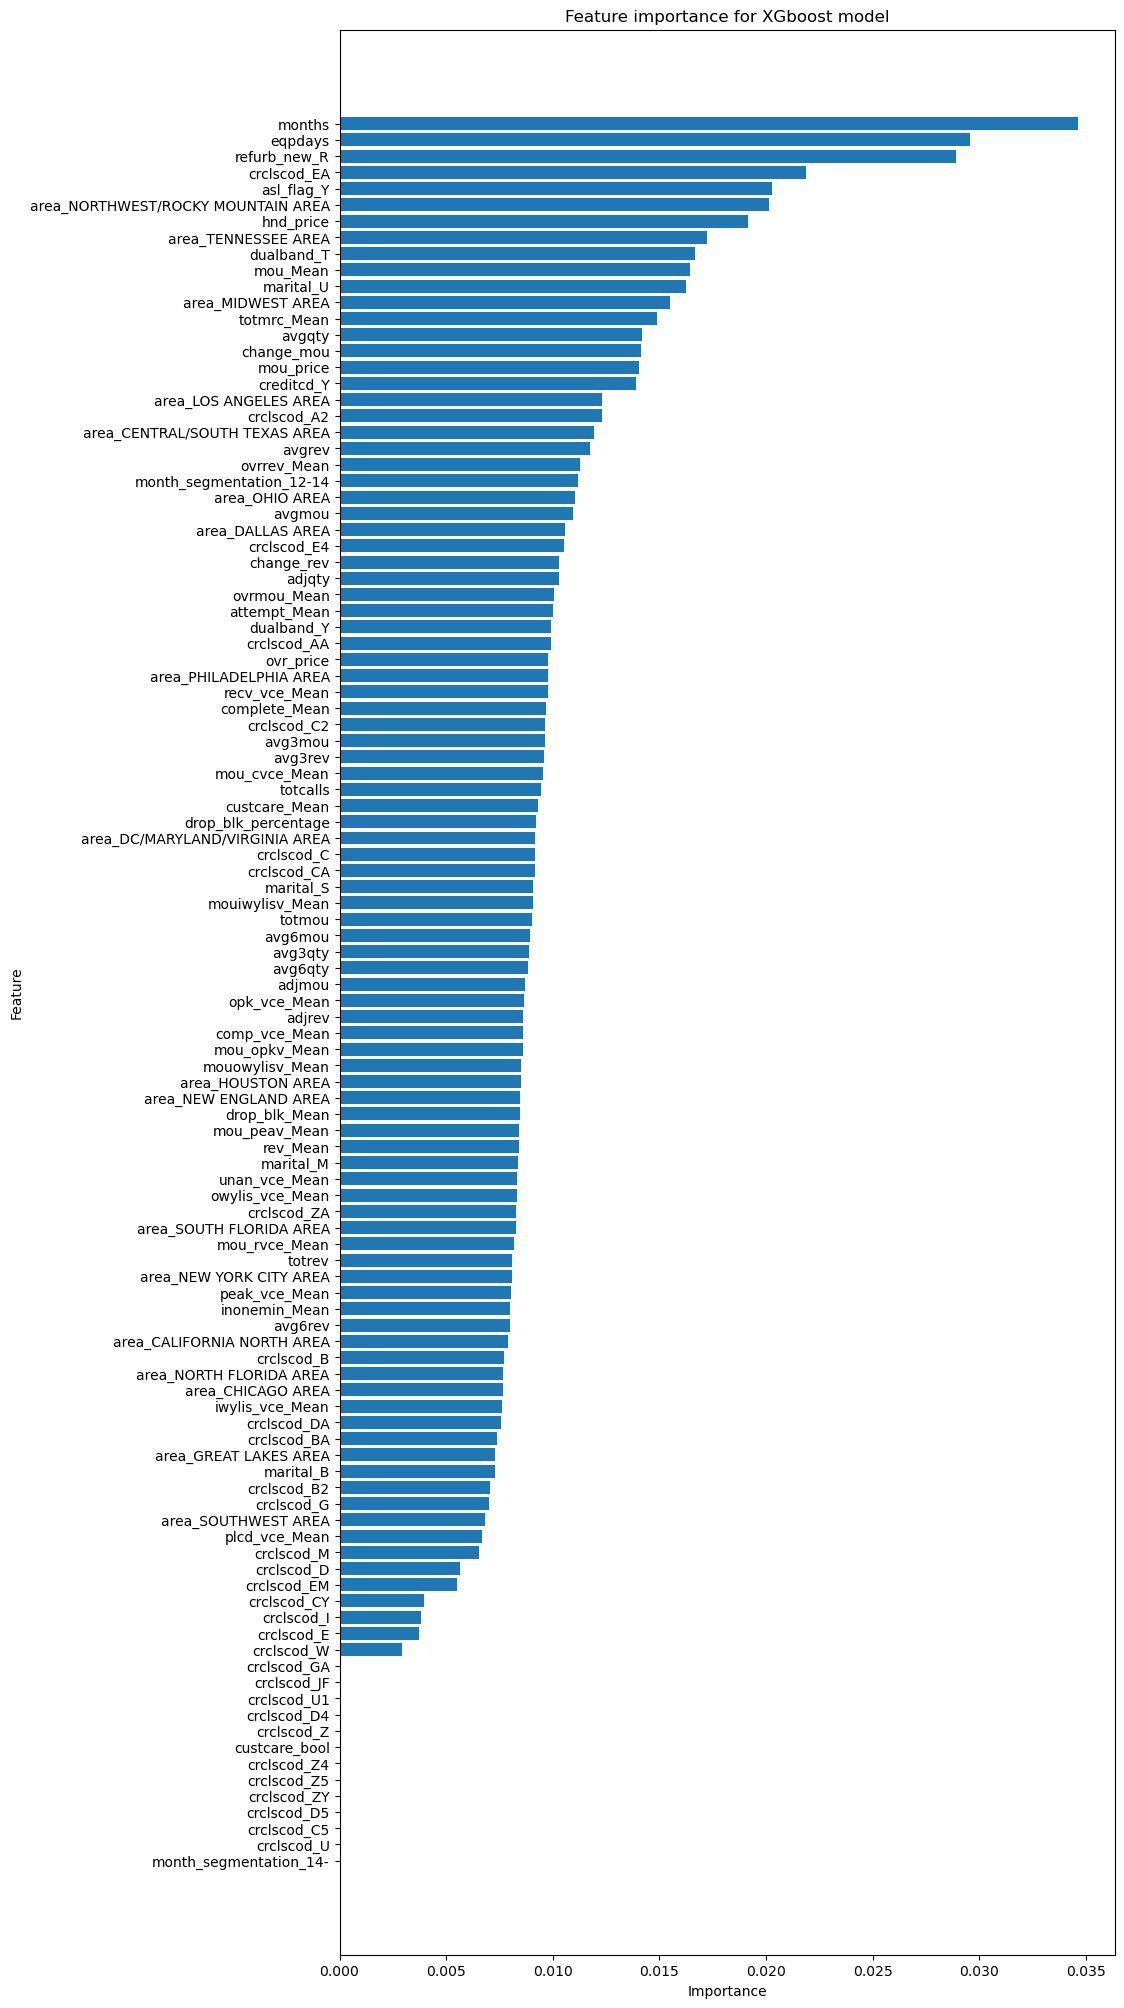

In [23]:
# Importâncias das features
importances = xgb_model.feature_importances_

# Nomes das features
features = X_train.columns

# Obter índices de ordenação (do maior para o menor)
indices = np.argsort(-importances)[::-1]

# Ordenar importâncias e features
sorted_importances = importances[indices]
sorted_features = features[indices]

# Criar gráfico
plt.figure(figsize=(10, 25))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance for XGboost model')
plt.show()

### Highlights models
- XGBoost performed slightly better than Random Forest, and both outperformed Logistic Regression.
- However, XGBoost's performance was still modest, with a recall and F1 score of just 0.62.
- Many crclscod categories were of no importance to the model.

We'll now try to improve the model's performance by applying feature engineering.

## K-means

In [24]:
#We need to standardize the data for better results
X_train_val3, X_test3_cat, y_train_val3, y_test3 = train_test_split(X, y, test_size = test_proportion, random_state=42)

X_train3_cat, X_val3_cat, y_train3, y_val3 = train_test_split(X_train_val3, y_train_val3, test_size=test_proportion/(1 - test_proportion), random_state=42)

to_categorical = False
to_log = True
to_standardize = True

X_train3, lb_columns, zscaler_columns = fit_transform_df(X_train3_cat)
X_val3 = transform_df(X_val3_cat, lb_columns, zscaler_columns)
X_test3 = transform_df(X_test3_cat, lb_columns, zscaler_columns)

X_train3.head()

,change_mou,change_rev,months,hnd_price,eqpdays,custcare_bool,log_totmrc_Mean,log_rev_Mean,log_mou_Mean,log_ovrmou_Mean,log_ovrrev_Mean,log_unan_vce_Mean,log_plcd_vce_Mean,log_recv_vce_Mean,log_comp_vce_Mean,log_inonemin_Mean,log_mou_cvce_Mean,log_mou_rvce_Mean,log_owylis_vce_Mean,log_mouowylisv_Mean,log_peak_vce_Mean,log_mou_peav_Mean,log_opk_vce_Mean,log_mou_opkv_Mean,log_drop_blk_Mean,log_attempt_Mean,log_complete_Mean,log_totcalls,log_totmou,log_totrev,log_adjrev,log_adjmou,log_adjqty,log_avgrev,log_avgmou,log_avgqty,log_avg3mou,log_avg3qty,log_avg3rev,log_avg6mou,log_avg6qty,log_avg6rev,log_mou_price,log_ovr_price,log_drop_blk_percentage,log_custcare_Mean,log_iwylis_vce_Mean,log_mouiwylisv_Mean,crclscod_A2,crclscod_AA,crclscod_B,crclscod_B2,crclscod_BA,crclscod_C,crclscod_C2,crclscod_C5,crclscod_CA,crclscod_CY,crclscod_D,crclscod_D4,crclscod_D5,crclscod_DA,crclscod_E,crclscod_E4,crclscod_EA,crclscod_EM,crclscod_G,crclscod_GA,crclscod_I,crclscod_JF,crclscod_M,crclscod_U,crclscod_U1,crclscod_W,crclscod_Z,crclscod_Z4,crclscod_Z5,crclscod_ZA,crclscod_ZY,asl_flag_Y,area_CALIFORNIA NORTH AREA,area_CENTRAL/SOUTH TEXAS AREA,area_CHICAGO AREA,area_DALLAS AREA,area_DC/MARYLAND/VIRGINIA AREA,area_GREAT LAKES AREA,area_HOUSTON AREA,area_LOS ANGELES AREA,area_MIDWEST AREA,area_NEW ENGLAND AREA,area_NEW YORK CITY AREA,area_NORTH FLORIDA AREA,area_NORTHWEST/ROCKY MOUNTAIN AREA,area_OHIO AREA,area_PHILADELPHIA AREA,area_SOUTH FLORIDA AREA,area_SOUTHWEST AREA,area_TENNESSEE AREA,dualband_T,dualband_Y,refurb_new_R,marital_B,marital_M,marital_S,marital_U,creditcd_Y,month_segmentation_12-14,month_segmentation_14-
0,0.137229,0.112101,0.661597,-1.170801,1.317358,0,-0.552446,0.145390,-0.019998,1.220178,1.295078,-0.042695,0.447983,-0.346645,0.382923,-0.626742,0.369908,-0.099087,0.227563,0.418425,0.381856,0.452166,0.089833,-0.051412,1.639342,0.445044,0.379459,-0.037979,-0.050029,-0.426353,-0.249198,-0.053656,-0.041899,-1.245357,-0.479211,-0.501136,-0.039147,-0.062601,0.135533,-0.216830,-0.216045,-0.273468,-0.183146,1.267798,2.695339,-0.614477,-0.517415,-0.545544,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
1,-2.792691,-1.097284,-1.057654,0.542580,-1.486444,0,0.843009,1.119779,0.645390,-0.193948,-0.335733,1.190075,0.976942,1.167238,0.985351,1.443892,0.581257,0.823024,1.020585,0.540261,0.848736,0.441860,1.325586,0.862077,1.257454,0.978664,0.987193,0.913046,0.599062,0.558827,0.432284,0.577833,0.884260,1.868507,1.181821,1.587616,0.833186,1.188132,1.274145,1.119858,1.512342,1.853573,-0.303094,0.721946,0.072156,-0.614477,0.813100,0.218320,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0
2,0.143109,0.069521,1.463914,-0.656786,0.859165,1,0.843009,0.301255,0.411256,-0.878825,-0.827712,-0.669582,-0.165958,-0.233752,-0.145680,-0.505998,-0.348760,-0.256988,-0.215857,-0.359503,-0.250544,-0.558237,-0.022685,-0.121907,0.295903,0.431209,0.541130,0.577908,0.501068,1.083135,1.080317,0.503342,0.581965,0.065266,-0.165614,-0.104837,0.395253,0.259939,0.286565,0.307711,0.195458,0.292399,-0.335079,-0.972990,-0.118045,-0.201650,-0.205460,-0.234551,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1
3,1.144251,2.143882,-1.057654,1.741947,-1.414983,1,1.859919,1.449699,0.062208,0.957320,0.886569,-0.151641,0.241272,0.157167,0.290720,0.324211,0.389720,-0.081350,0.428705,0.076420,0.400628,0.516404,-0.245363,-0.203597,0.391815,0.238471,0.287335,-0.371024,-0.184137,0.229625,0.173460,-0.240884,-0.407826,1.493279,0.318836,0.155337,-0.163076,-0.219209,1.119038,-0.168257,-0.189801,1.327216,0.098545,1.034406,0.370228,-0.201650,0.294261,0.602239,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,0.434190,0.025481,0.203130,-1.170801,0.026852,1,-0.128105,-0.094289,0.296283,-0.878825,-0.827712,0.888755,0.417

In [25]:
kmeans3 = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=1000)

# Fit model to data
kmeans3.fit(X_train3) 

# Print Metrics
print('Clusters: ', kmeans3.labels_) 
print('Inertia: ', kmeans3.inertia_) 

Clusters:  [2 1 2 ... 1 1 2]
Inertia:  1696917.3464740063


In [26]:
#Silhouette and inertia
num_clusters = [i for i in range(3, 19, 2)]

def X_to_clusters(x,list_to_drop):
    x_clean = x.copy()
    
    for feature in list_to_drop:
        if feature in x_clean.columns:
            x_clean.drop(feature, axis = 1, inplace = True)
        elif 'log_'+feature in x_clean.columns:
            x_clean.drop('log_'+feature, axis = 1, inplace = True)

        elif 'bool_'+feature in x_clean.columns:
            x_clean.drop('bool_'+feature, axis = 1, inplace = True)

        #Check if there is any categorical
        for col in x_clean.columns:
            if feature in col:
                x_clean.drop(col, axis = 1, inplace = True)
        
        
    return x_clean


def kmeans_metrics(num_clusters, x_vals):
    '''
    Fits a KMeans model for different values of k.
    Calculates an inertia score for each k value.

    Args:
        num_clusters: (list of ints)  - The different k values to try
        x_vals:       (array)         - The training data

    Returns: 
        inertia:      (list)          - A list of inertia scores, one for each \
                                      value of k
    '''

    inertia = []
    sil_score = []
    for i, num in enumerate(num_clusters):
        kms = MiniBatchKMeans(n_clusters=num, random_state=42, batch_size=1000)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
        sil_score.append(silhouette_score(x_vals, kms.labels_))
        print(f"{i/len(num_clusters)*100:.2f}% completed")
    return sil_score, inertia

#We need to drop high correlated features and one-hot-encoded features
x_cluster = X_to_clusters(X_train3,columns_to_drop + columns_high_correlated + columns_to_one_hot_enconde)
sil_score, inertia = kmeans_metrics(num_clusters, x_cluster)

0.00% completed
12.50% completed
25.00% completed
37.50% completed
50.00% completed
62.50% completed
75.00% completed
87.50% completed


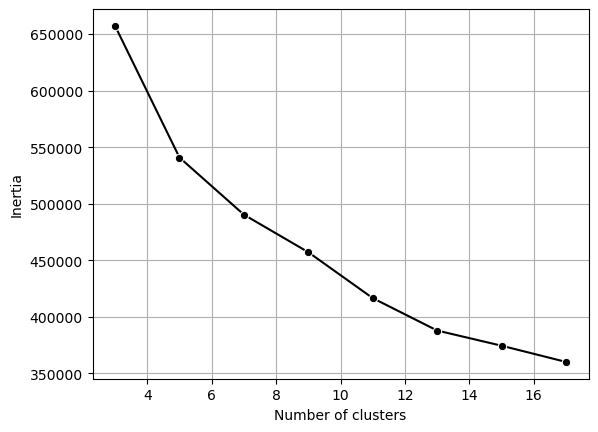

In [27]:
# Create an elbow plot
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o',color = 'black', markersize=6)
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");
plot.grid()
plt.show()

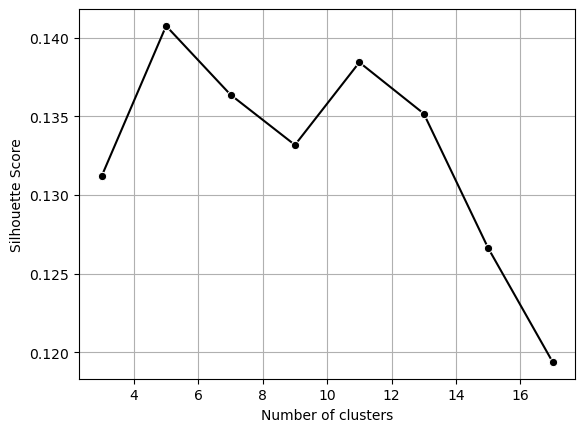

In [28]:
# Create a line plot of silhouette scores 
plot = sns.lineplot(x=num_clusters, y=sil_score,marker = 'o',color = 'black', markersize=6)
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Silhouette Score");
#plot.set_xticks(np.arange(0,50,5))
plot.grid()

plt.show()

In [29]:
#Lets choose 5 clusters to our model
n_optimal = 5

kmeans = MiniBatchKMeans(n_clusters=n_optimal, random_state=42, batch_size=1000)
kmeans.fit(x_cluster)

# Get the cluster labels and centroids
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

# Calculate the distance to the centroids
# Use pairwise_distances to calculate the distance from each point to its centroid
distances = pairwise_distances(x_cluster, centroids)

# Assign the distance to the corresponding centroid for each point
distance_to_centroid = distances[range(len(distances)), clusters]

In [30]:
X_train3_cluster = X_train3.copy()
X_val3_cluster = X_val3.copy()

X_train3_cluster['clusters'] = clusters
X_train3_cluster['distance_to_centroid'] = distance_to_centroid

In [31]:
## Creating these features in validation sample
x_cluster_val = X_to_clusters(X_val3,columns_to_drop + columns_high_correlated + columns_to_one_hot_enconde)

X_val3_cluster['clusters'] = kmeans.predict(x_cluster_val)

val_distances = pairwise_distances(x_cluster_val, kmeans.cluster_centers_)
val_distance_to_centroid = distances[range(len(val_distances)), X_val3_cluster['clusters']]

X_val3_cluster['distance_to_centroid'] = val_distance_to_centroid

### Comparing performance with XGboost

In [32]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train3_cluster, y_train3)

# Predict the validation data
y_pred = xgb_model.predict(X_val3_cluster)

#Calculate the performance
accuracy = accuracy_score(y_val3, y_pred)
conf_matrix = confusion_matrix(y_val3, y_pred)
class_report = classification_report(y_val3, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6076266934269945
Confusion Matrix:
[[3560 2448]
 [2244 3706]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      6008
           1       0.60      0.62      0.61      5950

    accuracy                           0.61     11958
   macro avg       0.61      0.61      0.61     11958
weighted avg       0.61      0.61      0.61     11958



In [33]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train3, y_train3)

# Predict the validation data
y_pred = xgb_model.predict(X_val3)

#Calculate the performance
accuracy = accuracy_score(y_val3, y_pred)
conf_matrix = confusion_matrix(y_val3, y_pred)
class_report = classification_report(y_val3, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6072921893293193
Confusion Matrix:
[[3654 2354]
 [2342 3608]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      6008
           1       0.61      0.61      0.61      5950

    accuracy                           0.61     11958
   macro avg       0.61      0.61      0.61     11958
weighted avg       0.61      0.61      0.61     11958



- We did not observe any improvement in our model's performance with the addition of k-means clustering.

### Weight of evidence (WOE)

In [34]:
def calculate_woe(df, feature, target):
    '''
    Calculates the Weight of Evidence (WOE) for a categorical feature in relation to the binary target.

    Args:
        df: DataFrame          - The dataframe containing the data
        feature: str           - The name of the categorical feature
        target: str            - The name of the binary target cAolumn (1 = event, 0 = non-event)
    
    Returns:
        woe_dic: Dictionary      - A dictionary with the WOE values for each category of the feature
    '''

    
    
    # Create a dataframe with total counts per category of the feature
    feature_total = df[[target, feature]].groupby(feature).count().reset_index()
    feature_event = df[[target, feature]].groupby(feature).sum().reset_index()
    
    # Merge total counts and event counts into one dataframe
    feature_woe = pd.merge(feature_total, feature_event, on=feature)
    feature_woe.columns = [feature, 'total', 'events']
    
    # Calculate the number of non-events (target=0)
    feature_woe['non_events'] = feature_woe['total'] - feature_woe['events']
    
    # Calculate event and non-event rates
    event_total = df[target].sum()
    non_event_total = df[target].count() - event_total
    
    feature_woe['event_rate'] = feature_woe['events'] / event_total
    feature_woe['non_event_rate'] = feature_woe['non_events'] / non_event_total
    
    # Calculate the WOE for each category
    feature_woe['WOE'] = np.log(feature_woe['event_rate'] / feature_woe['non_event_rate'])

    woe_dict = feature_woe.set_index(feature)['WOE'].to_dict()
    
    return woe_dict

In [35]:
woe_result_crc = calculate_woe(pd.concat([X_train3_cat, y_train3], axis = 1), 'crclscod', 'churn')
woe_result_area = calculate_woe(pd.concat([X_train3_cat, y_train3], axis = 1), 'area', 'churn')


In [36]:
columns_to_one_hot_enconde.remove('area')
columns_to_one_hot_enconde.remove('crclscod')

In [37]:
X_train3_woe, lb_columns, zscaler_columns = fit_transform_df(X_train3_cat)
X_val3_woe = transform_df(X_val3_cat, lb_columns, zscaler_columns)
X_test3_woe = transform_df(X_test3_cat, lb_columns, zscaler_columns)

X_train3_woe['area'] = X_train3_woe['area'].map(woe_result_area)
X_train3_woe['crclscod'] = X_train3_woe['crclscod'].map(woe_result_crc)

X_val3_woe['area'] = X_val3_woe['area'].map(woe_result_area)
X_val3_woe['crclscod'] = X_val3_woe['crclscod'].map(woe_result_crc)

In [38]:
#Return values of one-hot-encode list
columns_to_one_hot_enconde.append('area')
columns_to_one_hot_enconde.append('crclscod')

### Comparing performance with XGboost

In [39]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train3_woe, y_train3)

# Predict the validation data
y_pred = xgb_model.predict(X_val3_woe)

#Calculate the performance
accuracy = accuracy_score(y_val3, y_pred)
conf_matrix = confusion_matrix(y_val3, y_pred)
class_report = classification_report(y_val3, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6120588727211909
Confusion Matrix:
[[3734 2274]
 [2365 3585]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      6008
           1       0.61      0.60      0.61      5950

    accuracy                           0.61     11958
   macro avg       0.61      0.61      0.61     11958
weighted avg       0.61      0.61      0.61     11958



In [40]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train3, y_train3)

# Predict the validation data
y_pred = xgb_model.predict(X_val3)

#Calculate the performance
accuracy = accuracy_score(y_val3, y_pred)
conf_matrix = confusion_matrix(y_val3, y_pred)
class_report = classification_report(y_val3, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6072921893293193
Confusion Matrix:
[[3654 2354]
 [2342 3608]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      6008
           1       0.61      0.61      0.61      5950

    accuracy                           0.61     11958
   macro avg       0.61      0.61      0.61     11958
weighted avg       0.61      0.61      0.61     11958



### PCA Analysis

In [41]:
#fit PCA
n_components = 50  # Choose the number of components you want to keep
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train3_woe)
X_val_pca = pca.transform(X_val3_woe)

# Optional: Explained variance
explained_variance = pca.explained_variance_ratio_
#print(f"Explained variance by each principal component: {explained_variance}")

# Train XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)  # Use XGBRegressor for regression tasks
xgb_model.fit(X_train_pca, y_train3)

# Evaluate the model (e.g., accuracy, F1 score, etc.)
y_pred = xgb_model.predict(X_val_pca)

#Calculate the performance
accuracy = accuracy_score(y_val3, y_pred)
conf_matrix = confusion_matrix(y_val3, y_pred)
class_report = classification_report(y_val3, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6005184813513965
Confusion Matrix:
[[3689 2319]
 [2458 3492]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61      6008
           1       0.60      0.59      0.59      5950

    accuracy                           0.60     11958
   macro avg       0.60      0.60      0.60     11958
weighted avg       0.60      0.60      0.60     11958



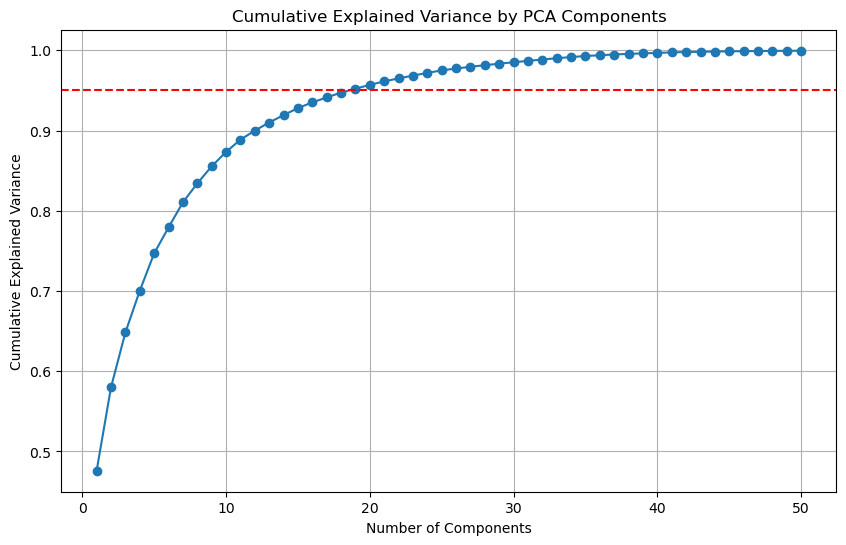

In [42]:
# Plot cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Threshold line at 95%
plt.grid()
plt.show()

In [43]:
print(X_train3_woe.shape, X_train3.shape)

(55799, 61) (55799, 108)


## Highlights features creation
- No performance improvement was found between the models.
- However, through PCA analysis, we observed that approximately 20 components are sufficient to explain 95% of the model's variance.
- Additionally, by applying Weight of Evidence (WOE) mapping to the categorical features area and crcslcod, we reduced the matrix from 108 columns to 61, achieving a 40% reduction.
- Therefore, since there was no degradation in performance, we will adopt WOE as a data preprocessing step.

## Feature selection

Let's drop the features that have less importance than a random variable.

In [44]:
X_train_feat_selection = X_train3_woe.copy()
X_val_feat_selection = X_val3_woe.copy()
X_test_feat_selection = X_test3_woe.copy()

In [45]:
def remove_features(X, y):
    X['random_feature'] = np.random.rand(len(X))
    
    # Fitting the model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
    xgb_model.fit(X, y)
    
    # Get feature importances
    importances = xgb_model.feature_importances_
    
    # Creating a dataframe 
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    })
    
    # Get random feature importance
    random_feature_importance = feature_importance_df.loc[feature_importance_df['feature'] == 'random_feature', 'importance'].values[0]
    
    # Select features with less importance than random
    less_important_features = feature_importance_df[feature_importance_df['importance'] < random_feature_importance]
    X.drop('random_feature', axis = 1, inplace = True)
    return less_important_features

In [46]:
cont = 0
while True:
    df_drop = remove_features(X_train_feat_selection, y_train3)
    if len(df_drop) == 0:
        cont+=1
        if cont>7:
            break
    print(f"Columns dropped: {df_drop['feature']}")
    X_train_feat_selection.drop(df_drop['feature'], axis = 1, inplace = True)

Columns dropped: 14         log_plcd_vce_Mean
54                 marital_B
56                 marital_S
60    month_segmentation_14-
Name: feature, dtype: object
Columns dropped: 15      log_comp_vce_Mean
19    log_owylis_vce_Mean
30             log_totrev
53              marital_M
Name: feature, dtype: object
Columns dropped: 39    log_avg6rev
Name: feature, dtype: object
Columns dropped: Series([], Name: feature, dtype: object)
Columns dropped: 19    log_peak_vce_Mean
Name: feature, dtype: object
Columns dropped: Series([], Name: feature, dtype: object)
Columns dropped: 4                  area
21    log_mou_opkv_Mean
27           log_adjrev
37          log_avg6qty
46           dualband_Y
Name: feature, dtype: object
Columns dropped: 38    log_iwylis_vce_Mean
Name: feature, dtype: object
Columns dropped: 17    log_mouowylisv_Mean
22      log_complete_Mean
Name: feature, dtype: object
Columns dropped: Series([], Name: feature, dtype: object)
Columns dropped: Series([], Name: feature, d

In [47]:
X_train_feat_selection.columns

Index(['change_mou', 'change_rev', 'months', 'crclscod', 'hnd_price',
       'eqpdays', 'custcare_bool', 'log_totmrc_Mean', 'log_rev_Mean',
       'log_mou_Mean', 'log_ovrmou_Mean', 'log_ovrrev_Mean',
       'log_unan_vce_Mean', 'log_recv_vce_Mean', 'log_inonemin_Mean',
       'log_mou_cvce_Mean', 'log_mou_rvce_Mean', 'log_mou_peav_Mean',
       'log_opk_vce_Mean', 'log_drop_blk_Mean', 'log_totcalls', 'log_totmou',
       'log_adjmou', 'log_adjqty', 'log_avgrev', 'log_avgmou', 'log_avgqty',
       'log_avg3mou', 'log_avg3qty', 'log_avg3rev', 'log_avg6mou',
       'log_mou_price', 'log_ovr_price', 'log_drop_blk_percentage',
       'log_custcare_Mean', 'log_mouiwylisv_Mean', 'asl_flag_Y', 'dualband_T',
       'refurb_new_R', 'marital_U', 'creditcd_Y', 'month_segmentation_12-14'],
      dtype='object')

In [48]:
#Lets also drop month_segmentation and marital
for col in X_train_feat_selection.columns:
    if "marital" in col or "month_segmentation" in col:
        X_train_feat_selection.drop(col, axis = 1, inplace = True)
        

In [49]:
#Evaluate model performance
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
xgb_model.fit(X_train_feat_selection, y_train3)

# Evaluate the model (e.g., accuracy, F1 score, etc.)
y_pred = xgb_model.predict(X_val_feat_selection[X_train_feat_selection.columns])

#Calculate the performance
accuracy = accuracy_score(y_val3, y_pred)
conf_matrix = confusion_matrix(y_val3, y_pred)
class_report = classification_report(y_val3, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6082120755979261
Confusion Matrix:
[[3699 2309]
 [2376 3574]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.61      6008
           1       0.61      0.60      0.60      5950

    accuracy                           0.61     11958
   macro avg       0.61      0.61      0.61     11958
weighted avg       0.61      0.61      0.61     11958



In [50]:
X_train_feat_selection.shape

(55799, 40)

## Hyperparameters optmization

In [51]:
X_train_final = X_train_feat_selection.copy()
X_val_final = X_val_feat_selection[X_train_feat_selection.columns].copy()
X_test_final = X_test_feat_selection[X_train_feat_selection.columns].copy()

In [52]:
# Create the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

param_dist = {
    'learning_rate': [0.05, 0.1, 0.15, 0.3],   # Placeholder: 0.3 (default)
    'n_estimators': [100, 150, 200,500,700],           # Placeholder: 100 (previous known good value)
    'max_depth': [5, 7, 6, 8],                 # Placeholder: 6 (good balance between complexity and performance)
    'min_sample_leaf':[10, 20, 30]             # Vai funcionar como regularizador. "poda"
#    'subsample': [0.8, 0.9, 1.0],              # Placeholder: 1.0 (default full data)
#    'colsample_bytree': [0.8, 1.0],            # Placeholder: 1.0 (default)
#    'reg_alpha': [0, 0.01, 0.1],               # Placeholder: 0 (default)
#    'reg_lambda': [1.0, 1.5, 2.0],             # Placeholder: 1.0 (default)
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,              # Reducing number of iterations for more targeted search
    scoring='accuracy',      # Change scoring metric based on your task
    cv=5,                    # 5-fold CV
    n_jobs=-1,               # Use all CPU cores
    random_state=42,
    verbose=1
)

In [53]:
# Train the model using GridSearchCV
random_search.fit(X_train_final, y_train3)

# Display the best hyperparameters found
print("Best hyperparameters: ", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\giode\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [11:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_sample_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


Best hyperparameters:  {'n_estimators': 150, 'min_sample_leaf': 20, 'max_depth': 5, 'learning_rate': 0.05}


In [54]:
# Use the best model to predict on the test set (if you have X_test)
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_val_final)

#Calculate the performance
accuracy = accuracy_score(y_val3, y_pred)
conf_matrix = confusion_matrix(y_val3, y_pred)
class_report = classification_report(y_val3, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.6139822712828232
Confusion Matrix:
[[3571 2437]
 [2179 3771]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.61      6008
           1       0.61      0.63      0.62      5950

    accuracy                           0.61     11958
   macro avg       0.61      0.61      0.61     11958
weighted avg       0.61      0.61      0.61     11958



## Model evaluation

Now we need to evaluate how our model will perform on completely new data (test sample).

In [55]:
#Preparing X_test
#X_test_final['area'] = X_test_final['area'].map(woe_result_area)
X_test_final['crclscod'] = X_test_final['crclscod'].map(woe_result_crc)

y_pred = best_xgb_model.predict(X_test_final)

#Calculate the performance
accuracy = accuracy_score(y_test3, y_pred)
conf_matrix = confusion_matrix(y_test3, y_pred)
class_report = classification_report(y_test3, y_pred)

# Print results
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      6005
           1       0.61      0.68      0.64      5953

    accuracy                           0.62     11958
   macro avg       0.63      0.62      0.62     11958
weighted avg       0.63      0.62      0.62     11958



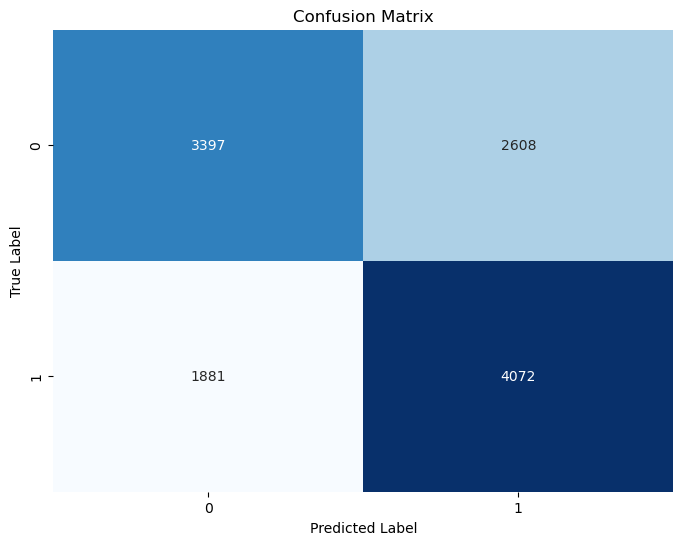

In [56]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=y_test3.unique(), yticklabels=y_test3.unique())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

- **Total Cases Evaluated**: 11,958
- **Churn Cases**: 5,953
- **Non-Churn Cases**: 6,005
- **Model Performance on Churn**: 
  - The model successfully identified 3,938 out of 5,953 churn cases (66% accuracy).
- **Predictions**:
  - The model predicted 6,425 cases as churn.
  - Among these, there were 2,487 false positives.
  
- **Next Steps**:
  - We need to evaluate how the threshold (the current threshold is set at 0.5) for labeling churn affects precision and recall.

In [57]:
thresholds = np.linspace(0,0.98,20)

y_probs = best_xgb_model.predict_proba(X_test_final)

precision = []
recall = []
f1 = []
false_positive_rate = []
false_negative_rate = []
true_positive_rate = []

for thresh in thresholds:
    y_predict = np.where(y_probs[:,1] >= thresh, 1, 0)
    precision.append(precision_score(y_test3, y_predict))
    recall.append(recall_score(y_test3, y_predict))
    f1.append(f1_score(y_test3, y_predict))
    cm = confusion_matrix(y_test3, y_predict)
    false_positive_rate.append(cm[0,1]/(cm[0,0] + cm[0,1]))
    
    false_negative_rate.append(cm[1,0]/(cm[1,1] + cm[1,0]))
    true_positive_rate.append(cm[1,1]/(cm[1,1] + cm[1,0]))

idx_max_f1 = np.argsort(-np.array(f1))[0]
max_f1 = f1[idx_max_f1]
max_threshold = thresholds[idx_max_f1]
recall_at_max = recall[idx_max_f1]
precision_at_max = precision[idx_max_f1]

C:\Users\giode\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
y_predict = np.where(y_probs[:,1] >= 0.5, 1, 0)

cm = confusion_matrix(y_test3, y_predict)
cm[0,0] + cm[0,1]

6005

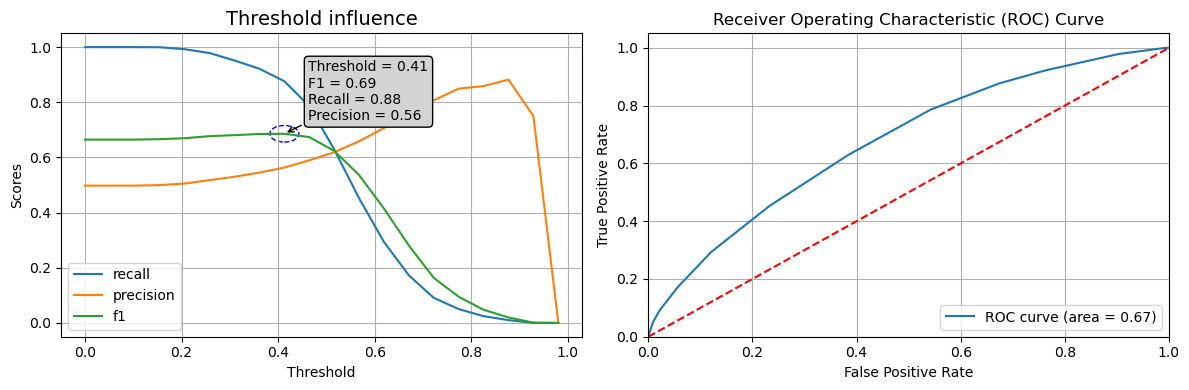

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x = thresholds, y = recall, ax = ax[0], label ='recall')
sns.lineplot(x = thresholds, y = precision, ax = ax[0], label ='precision')
sns.lineplot(x = thresholds, y = f1, ax = ax[0], label ='f1')

ax[0].set_title('Threshold influence',fontsize = 14)
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Scores')
ax[0].grid()
ax[0].legend()

#Annotate max f1
circle = plt.Circle((max_threshold, max_f1), 0.03, color='blue', fill=False, linestyle='--')
ax[0].add_artist(circle)

# Add annotation
annotation_text = f"Threshold = {max_threshold:.2f}\nF1 = {max_f1:.2f}\nRecall = {recall_at_max:.2f}\nPrecision = {precision_at_max:.2f}"
ax[0].annotate(annotation_text,
             xy=(max_threshold, max_f1),
             xytext=(max_threshold + 0.05, max_f1 + 0.05),  # Offset for clarity
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))


# ROC AUC curve

auc = np.abs(np.trapz(y = true_positive_rate, x = false_positive_rate))
# 5. Plot the ROC curve
sns.lineplot(x = false_positive_rate, y = true_positive_rate, ax = ax[1], label=f'ROC curve (area = {auc:.2f})')

ax[1].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc='lower right')
ax[1].grid()

plt.tight_layout()

plt.show()

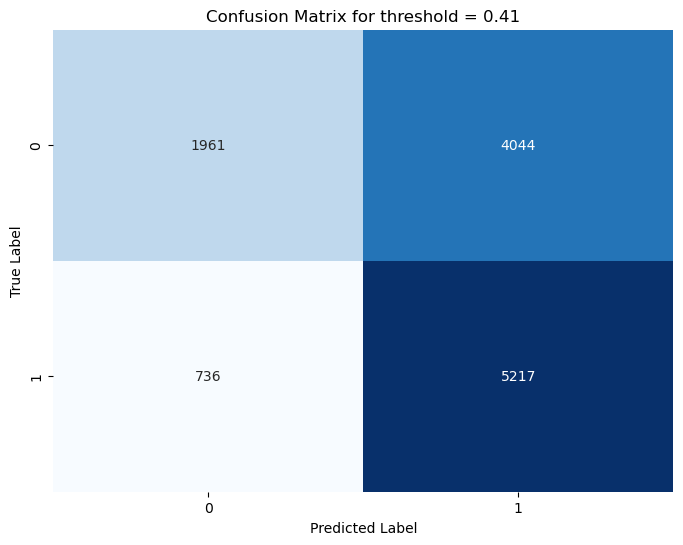

In [60]:
#Evaluate confusion matrix at threshold = 0.31
y_predict = np.where(y_probs[:,1] >= max_threshold, 1, 0)
conf_matrix_thr = confusion_matrix(y_test3, y_predict)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_thr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=y_test3.unique(), yticklabels=y_test3.unique())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for threshold = {max_threshold:.2f}')
plt.show()

- It is possible to see that the threshold impacts precision and recall, with smaller values yielding a higher recall.
- The threshold that maximizes the F1 score was 0.31. At this value, the model classified 87% of cases as churn, with a false positive rate of 80% and a false negative rate of 6%.
- It would be interesting to construct a cost matrix for false negatives and false positives to determine a value of threshold that **maximizes profit**.

# Profit simulation

In [75]:
#Get y probabilities
y_probs = best_xgb_model.predict_proba(X_test_final)
y_probs = [y[1] for y in y_probs]
#y_test3  -> right answer

bins_prob = np.linspace(0,1,21)[1:]

simulation_df = pd.DataFrame(columns = ['y_probs','y_true','bin'])
for i in range(len(y_probs)):
    dict_simulation = {}

    dict_simulation['y_probs'] = [y_probs[i]]
    dict_simulation['y_true'] = [y_test3.iloc[i]]
    
    bin = 0
    prob_bins = y_probs[i] - bins_prob[bin]
    while prob_bins > 0:
        bin += 1
        prob_bins = y_probs[i] - bins_prob[bin]

    dict_simulation['bin'] = [bin]
    df_concat = pd.DataFrame(dict_simulation)
    simulation_df = pd.concat([simulation_df, df_concat])
    

C:\Users\giode\AppData\Local\Temp\ipykernel_27216\3718952549.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  simulation_df = pd.concat([simulation_df, df_concat])


In [84]:
simulation_df['retained_customers'] = np.where(simulation_df['y_true']==0, 1, 0)
simulation_df['churn_customers'] = np.where(simulation_df['y_true']==1, 1, 0)

group_simulation = (simulation_df.groupby('bin').agg({'y_true':'mean','retained_customers':'sum', 'churn_customers':'sum'})
                    .reset_index().rename(columns = {'y_true':'churn %'}))

group_simulation.head()

,bin,churn %,retained_customers,churn_customers
0,2,0.069767,40,3
1,3,0.163158,159,31
2,4,0.192708,310,74
3,5,0.270718,396,147
4,6,0.281034,417,163


In [98]:
discount = 5
retained_churn_percentage = 0.3 #Percentage of customer that would churn that accepts the deal
mean_rev = df['rev_Mean'].mean()

group_simulation['decrease_revenue'] = group_simulation['retained_customers']*discount #Amount of money that we will lose from the retained_customers
group_simulation['increase_revenue'] = group_simulation['churn_customers']*retained_churn_percentage*(mean_rev - discount) #Amount of money that we will win from customers that will stay
group_simulation['delta_revenue'] = group_simulation['increase_revenue'] - group_simulation['decrease_revenue']
group_simulation['bin_probs %'] = bins_prob[group_simulation['bin']]*100

In [99]:
group_simulation

,bin,churn %,retained_customers,churn_customers,decrease_revenue,increase_revenue,delta_revenue,bin_probs,bin_probs %
0,2,0.069767,40,3,200,39.166987,-160.833013,0.15,15.0
1,3,0.163158,159,31,795,404.725531,-390.274469,0.20,20.0
2,4,0.192708,310,74,1550,966.119009,-583.880991,0.25,25.0
3,5,0.270718,396,147,1980,1919.182356,-60.817644,0.30,30.0
4,6,0.281034,417,163,2085,2128.072953,43.072953,0.35,35.0
5,7,0.321629,483,229,2415,2989.746664,574.746664,0.40,40.0
6,8,0.395147,698,456,3490,5953.382003,2463.382003,0.45,45.0
7,9,0.465311,894,778,4470,10157.305260,5687.305260,0.50,50.0
8,10,0.523664,936,1029,4680,13434.276494,8754.276494,0.55,55.0
9,11,0.562871,737,949,3685,12389.823511,8704.823511,0.60,60.0


As we can see, if we select a threshold of 35% **we would receive more money** from the customer that stayed compared with the total discount that we would give.

Nevertheless, this dataset was balanced and in a real application, we would have much less churn cases. Let's see how this simulation changes if we use a unbalance dataset

In [114]:
non_churn_sample_size

11360

In [127]:
proportion = 10/100

# Unir X e y em um único DataFrame temporário para amostragem
df_test = pd.concat([X_test_final.reset_index(), y_test3.reset_index()], axis=1)

# Separar as classes de churn e non-churn
churn_df = df_test[df_test['churn'] == 1]
non_churn_df = df_test[df_test['churn'] == 0]

# Definir o tamanho da amostra para cada grupo
churn_sample_size = int(proportion * len(df_test))  # 5% de churn
non_churn_sample_size = int(proportion * len(df_test))  # 95% de non-churn

# Amostrar cada grupo separadamente
churn_sample = churn_df.sample(n=int(churn_sample_size/2), random_state=42)
non_churn_sample = non_churn_df.sample(frac=1, random_state=42)

# Concatenar as amostras para formar o DataFrame final
sampled_df = pd.concat([churn_sample, non_churn_sample])

# Separar de volta em X e y desbalanceados
X_sampled = sampled_df.drop(columns=['churn', 'index'])
y_sampled = sampled_df['churn']

# Conferir a distribuição no dataset amostrado
print(X_sampled.columns)

Index(['change_mou', 'change_rev', 'months', 'crclscod', 'hnd_price',
       'eqpdays', 'custcare_bool', 'log_totmrc_Mean', 'log_rev_Mean',
       'log_mou_Mean', 'log_ovrmou_Mean', 'log_ovrrev_Mean',
       'log_unan_vce_Mean', 'log_recv_vce_Mean', 'log_inonemin_Mean',
       'log_mou_cvce_Mean', 'log_mou_rvce_Mean', 'log_mou_peav_Mean',
       'log_opk_vce_Mean', 'log_drop_blk_Mean', 'log_totcalls', 'log_totmou',
       'log_adjmou', 'log_adjqty', 'log_avgrev', 'log_avgmou', 'log_avgqty',
       'log_avg3mou', 'log_avg3qty', 'log_avg3rev', 'log_avg6mou',
       'log_mou_price', 'log_ovr_price', 'log_drop_blk_percentage',
       'log_custcare_Mean', 'log_mouiwylisv_Mean', 'asl_flag_Y', 'dualband_T',
       'refurb_new_R', 'creditcd_Y'],
      dtype='object')


In [128]:
#Repeat above calculations
y_probs = best_xgb_model.predict_proba(X_sampled)
y_probs = [y[1] for y in y_probs]
#y_sampled  -> right answer

bins_prob = np.linspace(0,1,21)[1:]

simulation_df = pd.DataFrame(columns = ['y_probs','y_true','bin'])
for i in range(len(y_probs)):
    dict_simulation = {}

    dict_simulation['y_probs'] = [y_probs[i]]
    dict_simulation['y_true'] = [y_sampled.iloc[i]]
    
    bin = 0
    prob_bins = y_probs[i] - bins_prob[bin]
    while prob_bins > 0:
        bin += 1
        prob_bins = y_probs[i] - bins_prob[bin]

    dict_simulation['bin'] = [bin]
    df_concat = pd.DataFrame(dict_simulation)
    simulation_df = pd.concat([simulation_df, df_concat])


simulation_df['retained_customers'] = np.where(simulation_df['y_true']==0, 1, 0)
simulation_df['churn_customers'] = np.where(simulation_df['y_true']==1, 1, 0)

group_simulation = (simulation_df.groupby('bin').agg({'y_true':'mean','retained_customers':'sum', 'churn_customers':'sum'})
                    .reset_index().rename(columns = {'y_true':'churn %'}))

discount = 5
retained_churn_percentage = 0.3 #Percentage of customer that would churn that accepts the deal
mean_rev = df['rev_Mean'].mean()

group_simulation['decrease_revenue'] = group_simulation['retained_customers']*discount #Amount of money that we will lose from the retained_customers
group_simulation['increase_revenue'] = group_simulation['churn_customers']*retained_churn_percentage*(mean_rev - discount) #Amount of money that we will win from customers that will stay
group_simulation['delta_revenue'] = group_simulation['increase_revenue'] - group_simulation['decrease_revenue']
group_simulation['bin_probs %'] = bins_prob[group_simulation['bin']]*100

C:\Users\giode\AppData\Local\Temp\ipykernel_27216\2119573087.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  simulation_df = pd.concat([simulation_df, df_concat])


In [129]:
group_simulation

,bin,churn %,retained_customers,churn_customers,decrease_revenue,increase_revenue,delta_revenue,bin_probs %
0,2,0.0,40,0,200,0.000000,-200.000000,15.0
1,3,0.02454,159,4,795,52.222649,-742.777351,20.0
2,4,0.028213,310,9,1550,117.500961,-1432.499039,25.0
3,5,0.024631,396,10,1980,130.556623,-1849.443377,30.0
4,6,0.058691,417,26,2085,339.447219,-1745.552781,35.0
5,7,0.054795,483,28,2415,365.558544,-2049.441456,40.0
6,8,0.070573,698,53,3490,691.950101,-2798.049899,45.0
7,9,0.080247,894,78,4470,1018.341658,-3451.658342,50.0
8,10,0.106017,936,111,4680,1449.178514,-3230.821486,55.0
9,11,0.103406,737,85,3685,1109.731294,-2575.268706,60.0


# Conclusion. Model description and next steps
- The final model chosen for deployment used:
  - Application of WOE on the features **'crclscod'** and **'area'** (mapped to a dictionary).
  - Selected features:
    - **change_mou**
    - **change_rev**
    - **months**
    - **crclscod**
    - **area**
    - **hnd_price**
    - **eqpdays**
    - **custcare_bool**
    - **totmrc_Mean**
    - **rev_Mean**
    - **mou_Mean**
    - **ovrmou_Mean**
    - **ovrrev_Mean**
    - **inonemin_Mean**
    - **mou_cvce_Mean**
    - **mou_rvce_Mean**
    - **owylis_vce_Mean**
    - **mouowylisv_Mean**
    - **mou_peav_Mean**
    - **complete_Mean**
    - **totcalls**
    - **adjqty**
    - **avgrev**
    - **avgmou**
    - **avgqty**
    - **avg3qty**
    - **avg3rev**
    - **avg6mou**
    - **mou_price**
    - **ovr_price**
    - **drop_blk_percentage**
    - **mouiwylisv_Mean**
    - **asl_flag**
    - **dualband**
    - **refurb_new**
    - **creditcd**
  
  - Applied **LabelBinarizer** on the following variables:
    - **asl_flag**
    - **dualband**
    - **refurb_new**
    - **creditcd**

- The best model was XGBoost with the following hyperparameters:
  - 'subsample': 0.8
  - 'reg_lambda': 1.0
  - 'reg_alpha': 0
  - 'n_estimators': 150
  - 'max_depth': 5
  - 'learning_rate': 0.1
  - 'colsample_bytree': 0.8
  
- We achieved an F1 score of **0.62** and a recall of **0.62** on the test sample.

- It is recommended to create a cost matrix to optimize the threshold that maximizes operational profit.
- Now we need to deploy this model to production

In [61]:
X_test_final.shape

(11958, 40)